Implementación del método visto para el análisis de frecuencia.

Primero desarrollaremos el modelo con el supuesto de que en el punto g---> 1 está el punto critico y, además, con la supusoción de que tenemos una matriz simétrica aletoria que cumple la ley de Dale y que está proxima a 1.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math as m

Definimos las funciones que vamos a utilizar

In [2]:
def lambda_pm(g):  # Compute λ± values
    term1 = (2 + 5 * g**2 - g**4 / 4)
    term2 = (1 / 4) * g * (8 + g**2)**(3/2)
    denominator = 2 * (1 - g**2)**3
    lambda_plus = (term1 + term2) / denominator
    lambda_minus = (term1 - term2) / denominator
    return lambda_minus, lambda_plus

def p_lambda(g): 
    lambda_minus, lambda_plus = lambda_pm(g)

    # Define λ values over the valid range
    lambda_val = np.geomspace(lambda_minus, lambda_plus,num=1000)

    # Compute prefactor (does not depend on xi)
    prefactor = (3**(1/6)) / (2 * np.pi * g**2 * lambda_val**2)

    # Initialize sum_terms as an array (to store values for each λ)
    sum_terms = np.zeros_like(lambda_val)

    # Summation over ξ = ±1
    for xi in [1, -1]:
        term1 = ((1 + g**2) / 2) * lambda_val - 1 / 9
        sqrt_arg = ((1 - g**2)**3 * lambda_val * (lambda_plus - lambda_val) * (lambda_val - lambda_minus)) / 3
        
        # Ensure non-negative values for sqrt
        sqrt_arg = np.maximum(sqrt_arg, 0)
        
        term2 = xi * np.sqrt(sqrt_arg)
        sum_terms += xi * np.cbrt(term1 + term2)  # Use np.cbrt() for safe cube root

    return lambda_val, prefactor * sum_terms  # Return λ values and p(λ)


Primero, hacemos la matriz W aleatoria cuya una descripción es que sea una guassiana de media zero y varianza de $\frac{1}{\sqrt N}$

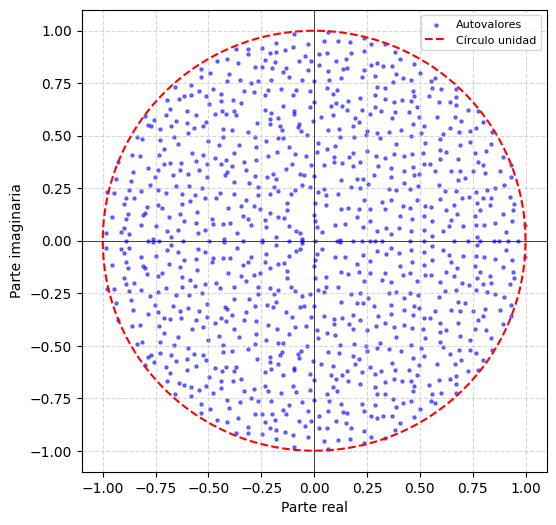

In [6]:
#Definimos las dimensiones de matriz
N=1000
W=np.random.normal (0,1/np.sqrt(N),(N,N)) #matriz normalizada

autovalores=np.linalg.eigvals(W)

# Ploteamos los autovalores en el plano complejo
plt.figure(figsize=(6, 6))
plt.scatter(autovalores.real, autovalores.imag, s=5, color='blue', alpha=0.5, label="Autovalores")

# Dibujamos un circulo centrado en cero y radio 1 para cogerlo de referencia 
theta = np.linspace(0, 2 * np.pi, 300)
plt.plot(np.cos(theta), np.sin(theta), 'r--', label="Círculo unidad")

plt.axhline(0, color='black', linewidth=0.5)
plt.axvline(0, color='black', linewidth=0.5)

plt.xlabel("Parte real")
plt.ylabel("Parte imaginaria")

plt.legend( loc="upper right", fontsize=8)
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()


A continuación, trazaremos las series temporales y la media del espectro de potencia. Para ello, describimos el sistema con x(t) en un tiempo discreto t.

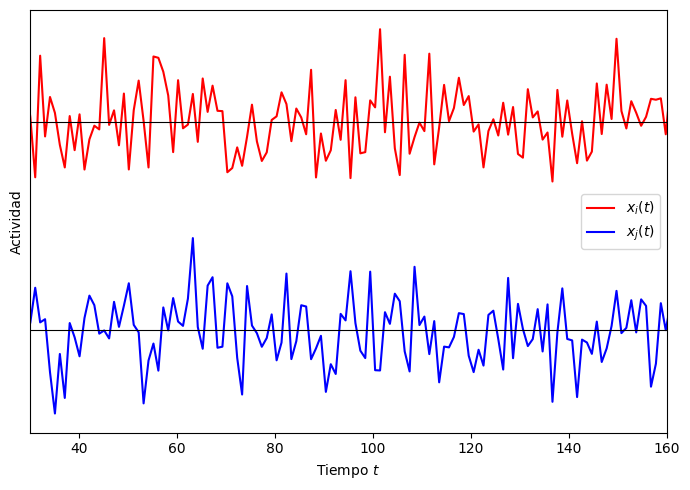

In [14]:
sigma = 1
g = 0.9
T = 200  # Tiempo total
dt = 1  # Paso por tiempo
n_iter = int(T / dt)
t = np.linspace(0, T, n_iter)  # Vector de tiempo

# Describimos la matriz A
A = -(np.eye(N,N) - g * W)

# generamos el ruido Gaussinao blanco 
chi = np.random.normal(0, sigma**2, (N, n_iter))

# Usamos el método de Euler para calcular la ecuación diferencial (mirar pagina)
x_t = np.zeros((N, n_iter))
for i in range(1, n_iter): #Podemos usar el metodo de euler porque la matriz A tiene autovalores reales
    x_t[:, i] = x_t[:, i-1] + np.dot(A, x_t[:, i-1]) * dt + chi[:, i] * np.sqrt(dt)

# Elegimos dos números aleatorios
i, j = np.random.choice(N, 2, replace=False)

# Graficamos 
plt.figure(figsize=(7, 5))
# Desfase visual (no afecta datos, solo para separar las curvas)
offset = 15  

# Señal 1
plt.plot(t, x_t[i, :], color='red', label=r"$x_i(t)$")
plt.axhline(0, color="black", linewidth=0.8)

# Señal 2 con desfase visual
plt.plot(t, x_t[j, :] - offset, color='blue', label=r"$x_j(t)$")
plt.axhline(-offset, color="black", linewidth=0.8)


plt.ylabel("Actividad")
plt.xlim(30, 160)  
plt.xlabel("Tiempo $t$")
plt.yticks([])  # Ocultar ticks del eje y
plt.legend(loc='center right', fontsize=10)
plt.tight_layout()
plt.show()


A continuación, introducimos la matriz de covarianza dependiente de la frecuencia

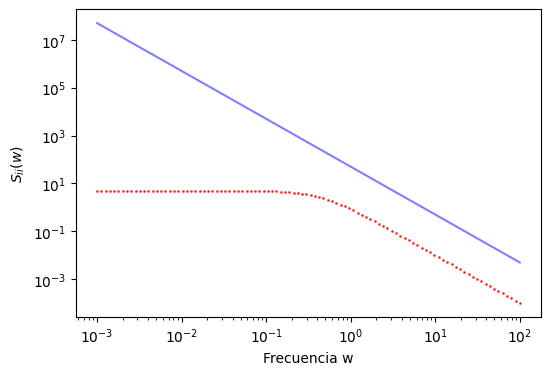

In [15]:
Nw = 100
w_all=np.geomspace(0.001,100,Nw) #Define el paso de frecuencia en una escala logaritmica
I=np.eye(N,N)

S_w_ii = []
for w in w_all:
    S_w = np.linalg.inv(A + 1j * w * I) @ np.linalg.inv(A.T - 1j * w * I) 
    diagonal_S_w = np.diag(S_w)
    S_w_ii.append(diagonal_S_w.mean())

S_w_ii = np.array(S_w_ii)

plt.figure(figsize=(6,4))
plt.scatter(w_all,np.real(S_w_ii),color='red',s=1, alpha=0.7)
plt.plot(w_all, w_all**(-2)*50, color='blue', label=r"$\sim w^{-2}$", alpha=0.5)
plt.xlabel('Frecuencia w')
plt.ylabel('$S_{ii}(w)$')
# plt.xlim(1e-3,10)
# plt.ylim(1e-2,100)
plt.loglog()
plt.show()


#El código se puede agilizar usando la descomposición de Cholesky o LU.


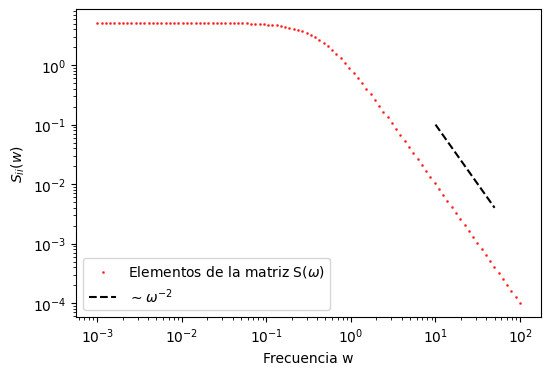

In [16]:
plt.figure(figsize=(6,4))
plt.scatter(w_all,np.real(S_w_ii),color='red',s=1, label = r"Elementos de la matriz S$(\omega)$", alpha=0.7)
x=np.linspace(10,50,100)
plt.plot(x, x**(-2)*10, 'k--', label=r"$\sim \omega^{-2}$")
plt.xlabel('Frecuencia w')
plt.ylabel('$S_{ii}(w)$')
plt.legend()
plt.loglog()
plt.show()

A continuación, hacemos una gráfica sobre la distribución de los autovalores de S(w) para tres frecuencias distintas: $\omega=0$, $\omega=0.5$ y $\omega=1$.

<>:39: SyntaxWarning: invalid escape sequence '\o'
<>:39: SyntaxWarning: invalid escape sequence '\o'
C:\Users\carlo\AppData\Local\Temp\ipykernel_11756\304564629.py:39: SyntaxWarning: invalid escape sequence '\o'
  plt.title("Distribución de autovalores de $S(\omega)$", fontsize=14)


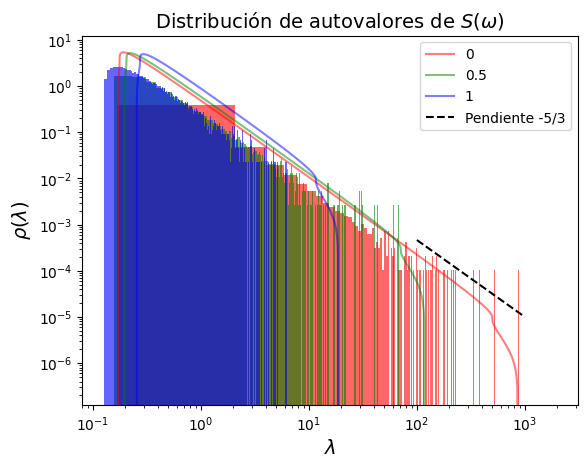

In [5]:
#Seleccionamos tres frecuencias dentro del rango de w. 0, 0.5 y 1.0
valores_w=[0, 0.5 , 1]
colores_w= ['red', 'green', 'blue'] #Colores para cada una de las frecuencias elegidas
autovalores_dict = {w: [] for w in valores_w} #Creamos un diccionario para guardar los autovalores de cada frecuencia
N=500
g=0.9
I=np.eye(N,N)

for w, color in zip(valores_w, colores_w): #Iteramos sobre las frecuencias elegidas y sus colores

    for i in range(10): #Realizamos 10 iteraciones, cambiando la frecuencia en cada iteración la matriz W.
        # De esa forma, podemos ver la convergencia 

        W=np.random.normal (0,1/np.sqrt(N),(N,N)) #Al ser aleatoria, la matriz W cambia en cada iteración
        A = -(np.eye(N,N) - g * W) 
        S_w = np.linalg.inv(A + 1j * w * I) @ np.linalg.inv(A.T - 1j * w * I)  
        autovalores = np.linalg.eigvalsh(S_w)  # Extraemos los autovalores reales
        autovalores_dict[w].extend(np.abs(autovalores))  #Guardamos en un lista plana, es decir, es una lista que no crea sublistas sino que 
        #añade los elementos de las sublistas a la lista principal
    
    autovalores_array = np.array(autovalores_dict[w]) #Convertimos la lista en un array
    #Calculamos la curva teórica para cada w de la lista
    g_w=g/np.sqrt(1+w**2)
    
    lambda_values, p_lambda_values = p_lambda(g_w)
    
    #Ploteamos la cadena de cadenas de autovalores en el histograma 
    plt.plot(lambda_values, p_lambda_values, color=color, label= w, alpha=0.5) #Ploteamos la curva teórica
    plt.hist(np.array(autovalores_dict[w]), bins=1000, density=True, color=color, alpha=0.6)

x_line = np.linspace(100,1000, 100)
y_line = (x_line**(-5/3))   # Escalamos para que se ajuste a la gráfica
plt.plot(x_line, y_line, color='black', linestyle='--', label="Pendiente -5/3")
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r"$\lambda$", fontsize=14)
plt.ylabel(r"$\rho(\lambda)$", fontsize=14)
plt.legend(fontsize=10, loc="upper right")
plt.title("Distribución de autovalores de $S(\omega)$", fontsize=14)
plt.show()



In [17]:
valores_w = [0, 0.5, 1.0]
colores_w = ['red', 'green', 'blue']
autovalores_dict = {w: [] for w in valores_w}
N = 500
g = 0.9
I = np.eye(N)

# Loop de simulaciones reales
for w, color in zip(valores_w, colores_w):
    for _ in range(10):
        W = np.random.normal(0, 1/np.sqrt(N), (N, N))
        A = -(np.eye(N) - g * W)
        S_w = np.linalg.inv(A + 1j * w * I) @ np.linalg.inv(A.T - 1j * w * I)
        autovalores = np.linalg.eigvalsh(S_w)
        autovalores_dict[w].extend(np.abs(autovalores))

<>:18: SyntaxWarning: invalid escape sequence '\o'
<>:28: SyntaxWarning: invalid escape sequence '\o'
<>:18: SyntaxWarning: invalid escape sequence '\o'
<>:28: SyntaxWarning: invalid escape sequence '\o'
C:\Users\carlo\AppData\Local\Temp\ipykernel_12104\3100431198.py:18: SyntaxWarning: invalid escape sequence '\o'
  plt.plot(lambda_values, p_lambda_values, color=color, alpha=0.6, label = f"$\omega = {w}$")  # Ploteo la curva teórica
C:\Users\carlo\AppData\Local\Temp\ipykernel_12104\3100431198.py:28: SyntaxWarning: invalid escape sequence '\o'
  plt.title("Distribución de autovalores de $S(\omega)$", fontsize=14)


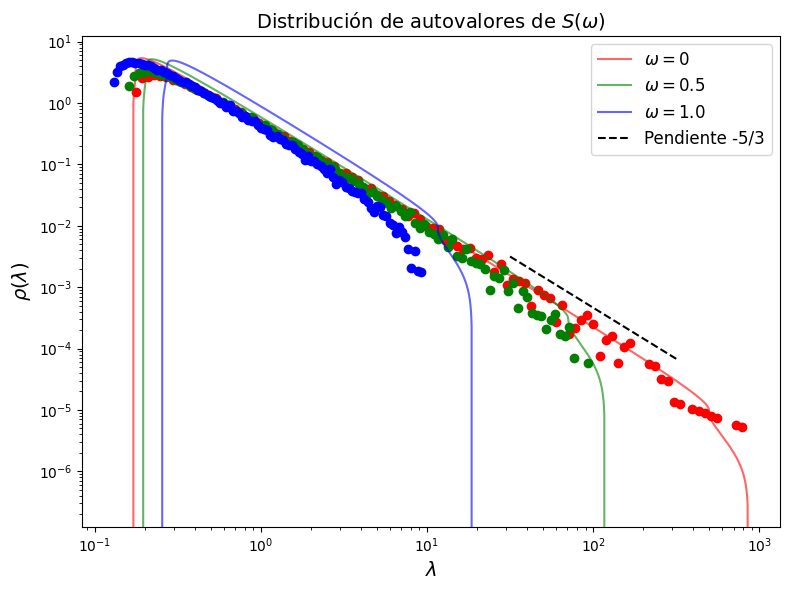

In [35]:
plt.figure(figsize=(8, 6))
for w, color in zip(valores_w, colores_w):
    autovalores_array = np.array(autovalores_dict[w])
    g_w = g / np.sqrt(1 + w**2)
    
    lambda_values, p_lambda_values = p_lambda(g_w)

    # Bins logarítmicos. Saco el mínimo y máximo de los autovalores para definir los bins y después lo equiespacio en escala logarítmica
    min_val = np.min(autovalores_array[autovalores_array > 0])  # evitar log(0)
    max_val = np.max(autovalores_array)
    bins_log = np.logspace(np.log10(min_val), np.log10(max_val), 100)
    
    #Le digo al histograma que use los bins logarítmicos y que normalice la densidad.
    counts, bins = np.histogram(autovalores_array, bins=bins_log, density=True)
    bin_centers = np.sqrt(bins[:-1] * bins[1:])  # Media geométrica

    plt.plot(bin_centers, np.sqrt(np.pi) * counts, 'o', color=color, alpha=1) #Multiplicamos por un factor raiz de 2pi o pi, por la transforma de Fourier
    plt.plot(lambda_values, p_lambda_values, color=color, alpha=0.6, label = f"$\omega = {w}$")  # Ploteo la curva teórica

# Pendiente -5/3
x_line = np.logspace(1.5, 2.5, 100)
plt.plot(x_line, x_line**(-5/3), 'k--', label="Pendiente -5/3")

plt.xscale('log')
plt.yscale('log')
plt.xlabel(r"$\lambda$", fontsize=14)
plt.ylabel(r"$\rho(\lambda)$", fontsize=14)
plt.title("Distribución de autovalores de $S(\omega)$", fontsize=14)
plt.legend(fontsize=12, loc="upper right")
plt.tight_layout()
plt.show()

